<h1> Assignment 3 - Computer Vision (CSc8830) </h1>
<h3> Instructor: Dr. Ashwin Ashok - Spring 2024 </h3>
<h3> Student name: Reza Mansouri </h3>
<h4> Repository address: https://github.com/rezmansouri/csc8830/tree/main/Assignment%203

# Question 1
<h4>Capture a 10 sec video footage using a camera of your choice. The footage should be taken with the camera in hand and you need to pan the camera slightly from left-right or right-left during the 10 sec duration. Pick any image frame from the 10 sec video footage. Pick a region of interest corresponding to an object in the image. Crop this region from the image. Then use this cropped region to compare with randomly picked 10 images in the dataset of 10 sec video frames, to see if there is a match for the object in the scenes from the 10 images. For comparison use sum of squared differences (SSD) or normalized correlation.</h4>

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

### Reading the video and getting the frames

In [2]:
def get_video_frames(path):
    video = cv.VideoCapture(path)
    ret, frame = video.read()
    frames = []
    while ret:
        frame = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
        frames.append(frame)
        ret, frame = video.read()
    video.release()
    return np.array(frames)

In [3]:
frames_dataset = get_video_frames('input/video.mp4')

### Showing 6 consecutive frames

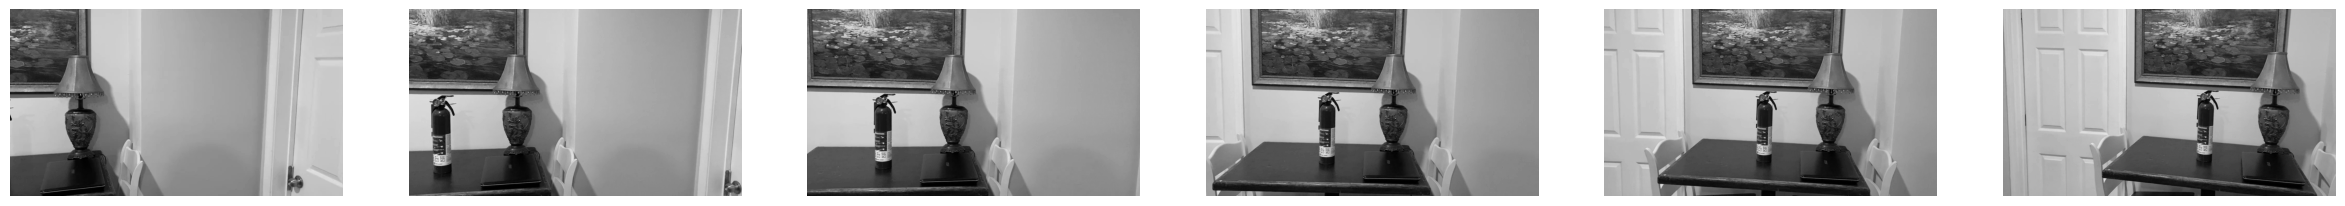

In [4]:
n_frames = len(frames_dataset)
fig, axes = plt.subplots(1, 6, figsize=(30, 10))
step = n_frames // 6
for i in range(0, n_frames, step):
    axes[i//step].axis('off')
    axes[i//step].imshow(frames_dataset[i], cmap='gray')

### Choosing a target frame and an object

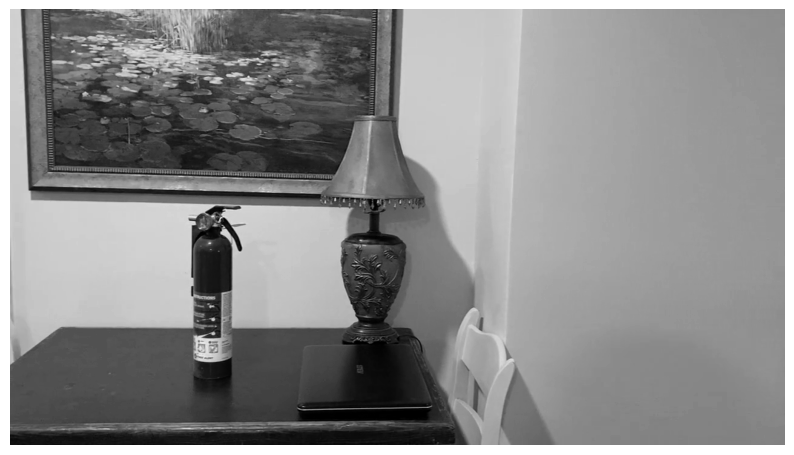

In [5]:
target_frame_ix = 100
target_frame = frames_dataset[target_frame_ix]
plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(target_frame, cmap='gray')
plt.show()

### Cropping the object out

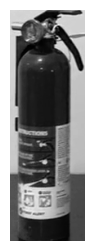

In [6]:
object = target_frame[325:610, 293:385]
plt.figure(figsize=(5, 3))
plt.axis('off')
plt.imshow(object, cmap='gray')
plt.show()

### Getting 10 random frames

In [11]:
random_frames_ix = np.random.choice(np.arange(n_frames), size=10, replace=False)
print(random_frames_ix)

[260 246  62  84 241 243 155 129 267 164]


In [10]:
for i in random_frames_ix:
    image = Image.fromarray(frames_dataset[i])
    image.save(f'5_frame_{i}.jpg')

#### Sliding a window of the same size as the object on each frame and computing $SSD$

In [8]:
differences = []
coordinates = []
for ix in random_frames_ix:
    frame = frames_dataset[ix]
    ssds = []
    coords = []
    for i in range(0, frame.shape[0] - object.shape[0], 30):
        for j in range(0, frame.shape[1] - object.shape[1], 30):
            candidate = frame[i:i+object.shape[0], j:j+object.shape[1]]
            ssd = np.sum(np.power(candidate-object, 2))
            ssds.append(ssd)
            coords.append((i, j))
    differences.append(ssds)
    coordinates.append(coords)

#### Finding the best match $min(SSD)$ in each frame

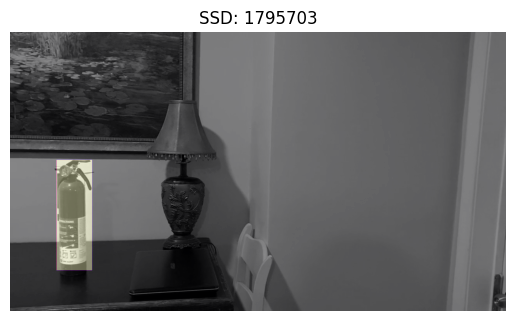

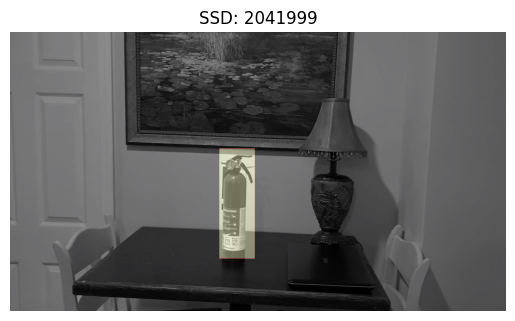

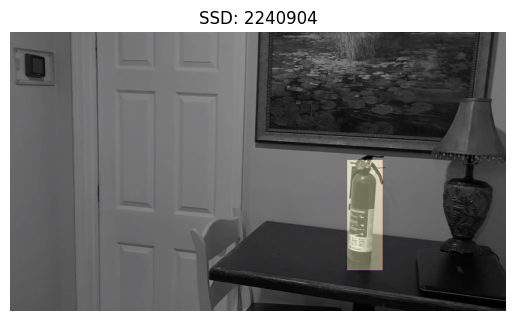

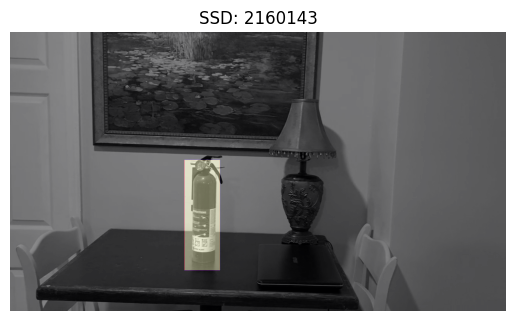

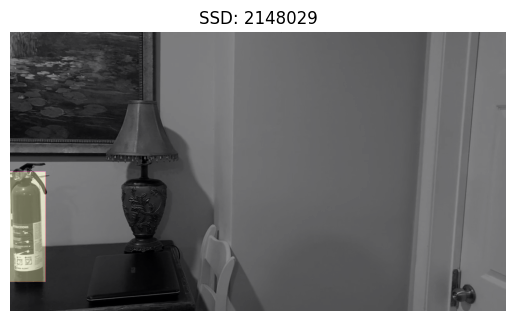

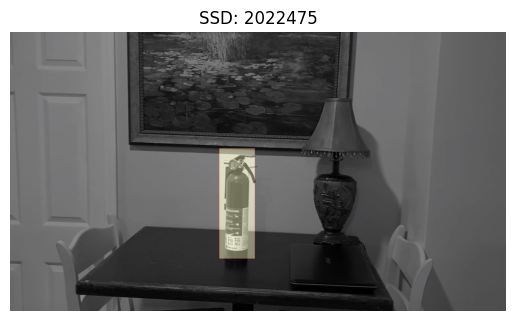

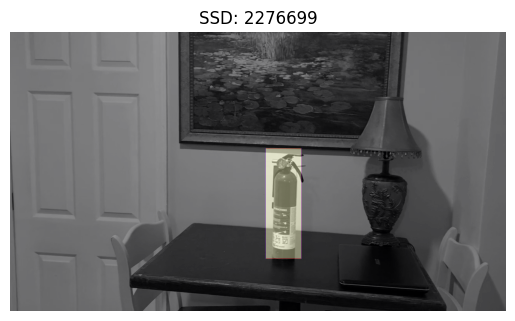

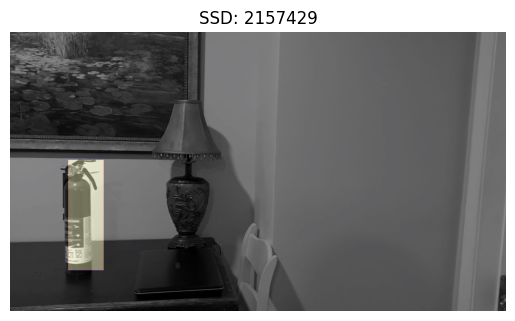

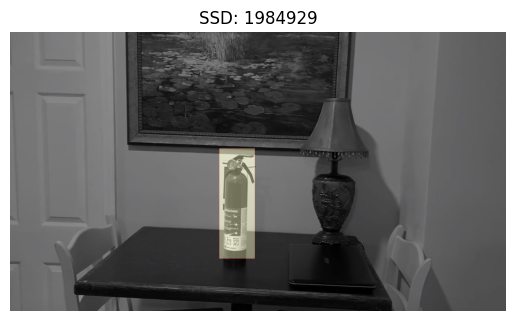

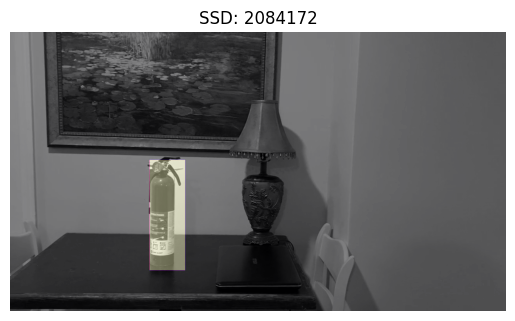

In [9]:
for i, ix in enumerate(random_frames_ix):
    minimun_diff_ix = np.argmin(differences[i])
    coords = coordinates[i][minimun_diff_ix]
    overlay = np.zeros(frames_dataset.shape[1:])
    overlay[coords[0]:coords[0]+object.shape[0], coords[1]:coords[1]+object.shape[1]] = 1
    plt.title(f'SSD: {differences[i][minimun_diff_ix]}')
    plt.axis('off')
    plt.imshow(frames_dataset[ix], cmap='gray')
    plt.imshow(overlay, cmap='magma', alpha=.4)
    plt.show()

# Question 2

## Part a

<h4>Derive the motion tracking equation from fundamental principles. Select any 2 consecutive frames from the set from problem 1 and compute the motion function estimates.</h4>

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/1.png" alt="fig" width="700"/>

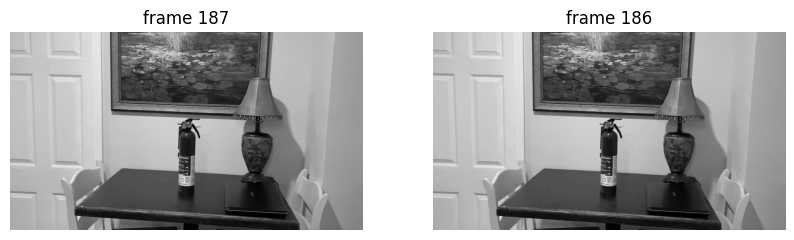

In [10]:
random_frame_ix = np.random.randint(low=0, high=n_frames-1)
frame_1 = frames_dataset[random_frame_ix]
frame_2 = frames_dataset[random_frame_ix+1]
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title(f'frame {random_frame_ix + 1}')
plt.imshow(frame_2, cmap='gray')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title(f'frame {random_frame_ix}')
plt.imshow(frame_1, cmap='gray')
plt.show()

In [11]:
frame_block = np.concatenate([np.expand_dims(frame_1, 2), np.expand_dims(frame_2, 2)], axis= 2, dtype=np.float32)

### Step 1: finding $I_x$, $I_y$, and $I_t$ using finite differences

In [12]:
Iy = np.mean(np.diff(frame_block, axis=0), axis=2)
Ix = np.mean(np.diff(frame_block, axis=1), axis=2)
It = np.diff(frame_block, axis=2).squeeze()

In [13]:
Iy = Iy[:, :-1]
Ix = Ix[:-1, :]
It = It[:-1, :-1]

### Step 2: computing magnitued and direction of optical flow $(u, v)$

In [14]:
denominator = np.sqrt(Ix ** 2 + Iy ** 2)
nominator = np.abs(It)
un_magnitude = np.zeros(nominator.shape)
defined_indices = denominator!=0
un_magnitude[defined_indices] = nominator[defined_indices] / denominator[defined_indices]

In [15]:
un_direction = np.arctan2(Iy, Ix)

In [42]:
u = -un_magnitude * np.cos(un_direction)
v = -un_magnitude * np.sin(un_direction)

### Plotting the results for a 10 by 10 patch

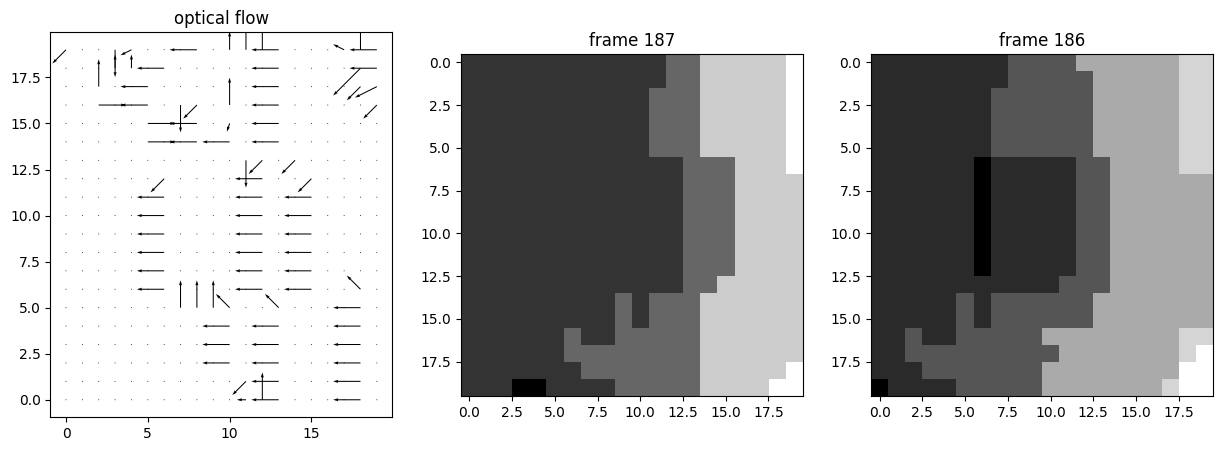

In [54]:
k, l = 130, 130
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title('optical flow')
axs[0].quiver(u[k:k+20, l:l+20], v[k:k+20, l:l+20], scale=25)
plt.gca().set_aspect('equal', adjustable='box')
axs[1].set_title(f'frame {random_frame_ix + 1}')
axs[1].imshow(frame_2[k:k+20, l:l+20], cmap='gray')
axs[2].set_title(f'frame {random_frame_ix}')
axs[2].imshow(frame_1[k:k+20, l:l+20], cmap='gray')
plt.show()

## Part b

<h4>Derive the procedure for performing Lucas-Kanade algorithm for motion tracking when the motion is known to be affine: 

$u(x,y) = a_1*x + b_1*y + c_1$, $v(x,y) = a_2*x + b_2*y + c_2$
</h4>

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/2.jpg" alt="fig" width="700"/>

# Question 3
<h4>Fix a marker on a wall or a flat vertical surface. From a distance D, keeping the camera stationed static (not handheld and mounted on a tripod or placed on a flat surface), capture an image such that the marker is registered. Then translate the camera by T units along the axis parallel to the ground (horizontal) and then capture another image, with the marker being registered. Compute D using disparity based depth estimation in stereo-vision theory. (Note: you can pick any value for D and T. Keep in mind that T cannot be large as the marker may get out of view. Of course this depends on D)
</h4>

As the solution requires the focal length, I used the oak-d camera, because I obtained its focal length in assignment 1 during calibration ($f_x \approx f_y = f$). Here is my experiment setup. The marker is the small orange label on the wall.

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/3.jpg" alt="fig" width="900"/>

Depth estimation via disparity is finding $D$ by knowing $f$ (focal length), $T$ (the translation magnitude), $l_1$, and $l_2$ which are the distances of the projection of the point $P$ from the left border of the image planes.

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/3_2.jpg" alt="fig" width="400"/>

Here are my knowns:
- $T = 9$ cm
- $f = 1430$ px (from assignment 1)
- $l_1 = 645$ px
- $l_2 = 870$ px

And I want to estimate $D$ which has the ground truth of $60$ cm.

$$
D = \frac{f \times T}{l_2 -  l_1}
$$

$$
D = \frac{1430 \times 9}{870 -  645} = \frac{12870}{225} = 57.2 \approx 60\ cm
$$

# Question 4
<h4>For the video (problem 1) you have taken, plot the optical flow vectors on each frame using MATLAB’s optical flow codes. (i) treating every previous frame as a reference frame (ii) treating every 11th frame as a reference frame (iii) treating every 31st frame as a reference frame</h4>

I copied the code and output from my `.mlx` file for this question for showing it here. Please find the live script in the attachments. The plots are for some single frames. The full version is available via running the `.mlx` file.

Reading the video:
```matlab
vidReader = VideoReader('./input/video.mp4','CurrentTime',0);
```
Specifying the optical flow estimation method as `opticalFlowHS`.
```matlab
opticFlow = opticalFlowHS
```
```matlab
>>> opticFlow = 
    opticalFlowHS with properties:

              Smoothness: 1
            MaxIteration: 10
      VelocityDifference: 0
```

### 1. Plotting the optical flow vectors when treating every previous frame as a reference frame.

```matlab
h = figure;
movegui(h);
hViewPanel = uipanel(h,'Position',[0 0 1 1],'Title','Plot of Optical Flow Vectors');
hPlot = axes(hViewPanel);

while hasFrame(vidReader)
    frameRGB = readFrame(vidReader);
    frameGray = im2gray(frameRGB);  
    flow = estimateFlow(opticFlow,frameGray);
    imshow(frameRGB)
    hold on
    plot(flow,'DecimationFactor',[5 5],'ScaleFactor',60,'Parent',hPlot);
    hold off
    pause(10^-3)
end
opticFlow.reset();
vidReader = VideoReader('./input/video.mp4','CurrentTime',0);
```

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/4_1.png" alt="fig" width="800"/>

### 2. Plotting the optical flow vectors when treating 11th frame as a reference frame.

```matlab
h = figure;
movegui(h);
hViewPanel = uipanel(h,'Position',[0 0 1 1],'Title','Plot of Optical Flow Vectors');
hPlot = axes(hViewPanel);
frameCount = 0;

while hasFrame(vidReader)
    frameCount = frameCount + 1;
    if mod(frameCount, 11) == 0
        frameRGB = readFrame(vidReader);
        frameGray = im2gray(frameRGB);  
        flow = estimateFlow(opticFlow,frameGray);
        imshow(frameRGB)
        hold on
        plot(flow,'DecimationFactor',[5 5],'ScaleFactor',60,'Parent',hPlot);
        hold off
        pause(10^-3)
    end
end
opticFlow.reset();
vidReader = VideoReader('./input/video.mp4','CurrentTime',0);
```

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/4_2.png" alt="fig" width="800"/>

### 3. Plotting the optical flow vectors when treating 31st frame as a reference frame.

```matlab
h = figure;
movegui(h);
hViewPanel = uipanel(h,'Position',[0 0 1 1],'Title','Plot of Optical Flow Vectors');
hPlot = axes(hViewPanel);
frameCount = 0;

while hasFrame(vidReader)
    frameCount = frameCount + 1;
    if mod(frameCount, 31) == 0
        frameRGB = readFrame(vidReader);
        frameGray = im2gray(frameRGB);  
        flow = estimateFlow(opticFlow,frameGray);
        imshow(frameRGB)
        hold on
        plot(flow,'DecimationFactor',[5 5],'ScaleFactor',60,'Parent',hPlot);
        hold off
        pause(10^-3)
    end
end
opticFlow.reset();
vidReader = VideoReader('./input/video.mp4','CurrentTime',0);
```

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/4_3.png" alt="fig" width="800"/>

# Question 5
<h4>Run the feature-based matching object detection on the images from problem (1).
MATLAB (not mandatory for this problem).

I copied the code and output from my `.mlx` file for this question for showing it here. Please find the live script in the attachments.

## Step 1: Read Images
Read the reference image containing the object of interest.
```matlab
boxImage = imread('./input/5_object.jpg');
sceneImage = imread('./input/5_frame_15.jpg');
```

## Step 2: Detect Point Features
Detect point features in both images.
```matlab
boxPoints = detectSURFFeatures(boxImage);
scenePoints = detectSURFFeatures(sceneImage);
```

## Step 3: Extract Feature Descriptors
Extract feature descriptors at the interest points in both images.
```matlab
[boxFeatures, boxPoints] = extractFeatures(boxImage, boxPoints);
[sceneFeatures, scenePoints] = extractFeatures(sceneImage, scenePoints);
```

## Step 4: Find Putative Point Matches
Match the features using their descriptors.
```matlab
boxPairs = matchFeatures(boxFeatures, sceneFeatures);
```

Display putatively matched features.
```matlab
matchedBoxPoints = boxPoints(boxPairs(:, 1), :);
matchedScenePoints = scenePoints(boxPairs(:, 2), :);
figure;
showMatchedFeatures(boxImage, sceneImage, matchedBoxPoints, ...
    matchedScenePoints, 'montage');
title('Putatively Matched Points (Including Outliers)');
```

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/5_1.png" alt="fig" width="800"/>

## Step 5: Locate the Object in the Scene Using Putative Matches
```matlab
[tform, inlierIdx] = estgeotform2d(matchedBoxPoints, matchedScenePoints, 'affine');
inlierBoxPoints   = matchedBoxPoints(inlierIdx, :);
inlierScenePoints = matchedScenePoints(inlierIdx, :);
```

Get the bounding polygon of the reference image.
```matlab
boxPolygon = [1, 1;...                           % top-left
    size(boxImage, 2), 1;...                 % top-right
    size(boxImage, 2), size(boxImage, 1);... % bottom-right
    1, size(boxImage, 1);...                 % bottom-left
    1, 1];                   % top-left again to close the polygon
```

Transform the polygon into the coordinate system of the target image. The transformed polygon indicates the location of the object in the scene.
```matlab
newBoxPolygon = transformPointsForward(tform, boxPolygon);
```

Display the detected object.
```matlab
figure;
imshow(sceneImage);
hold on;
line(newBoxPolygon(:, 1), newBoxPolygon(:, 2), Color='y');
title('Detected Box');
```

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/5_2.png" alt="fig" width="800"/>

## Step 6: Doing the same for 9 other random frames
```matlab
paths = ["./input/5_frame_84.jpg","./input/5_frame_85.jpg","./input/5_frame_92.jpg",
         "./input/5_frame_119.jpg","./input/5_frame_163.jpg","./input/5_frame_181.jpg",
         "./input/5_frame_199.jpg","./input/5_frame_267.jpg","./input/5_frame_155.jpg"];
for i=1:numel(paths)
    sceneImage = imread(paths(i));
    scenePoints = detectSURFFeatures(sceneImage);

    [sceneFeatures, scenePoints] = extractFeatures(sceneImage, scenePoints);

    boxPairs = matchFeatures(boxFeatures, sceneFeatures);

    matchedBoxPoints = boxPoints(boxPairs(:, 1), :);
    matchedScenePoints = scenePoints(boxPairs(:, 2), :);

    [tform, inlierIdx] = estgeotform2d(matchedBoxPoints, matchedScenePoints, 'affine');

    boxPolygon = [1, 1;...
    size(boxImage, 2), 1;...
    size(boxImage, 2), size(boxImage, 1);...
    1, size(boxImage, 1);...
    1, 1];
    newBoxPolygon = transformPointsForward(tform, boxPolygon);

    figure;
    imshow(sceneImage);
    hold on;
    line(newBoxPolygon(:, 1), newBoxPolygon(:, 2), Color='y');
    title('Detected Box');
end
```

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/5_3.png" alt="fig" width="800"/>

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/5_4.png" alt="fig" width="800"/>

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/5_5.png" alt="fig" width="800"/>

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/5_6.png" alt="fig" width="800"/>

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/5_7.png" alt="fig" width="800"/>

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/5_8.png" alt="fig" width="800"/>

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/5_9.png" alt="fig" width="800"/>

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/5_10.png" alt="fig" width="800"/>

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/5_11.png" alt="fig" width="800"/>

# Question 6
<h4>
Refer to the Bag of Features example MATLAB source code provided in the classroom’s classwork page. In your homework, pick an object category that would be commonly seen in any
household (e.g. cutlery) and pick 5 object types (e.g. for cutlery pick spoon, fork, butter knife, cutting knife, ladle). Present your performance evaluation.
</h4>

I copied the code and output from my `.mlx` file for this question for showing it here. Please find the live script in the attachments.

## Load Data
```matlab
imds = imageDatastore('input/question_6','IncludeSubfolders',true,'LabelSource','foldernames');
tbl = countEachLabel(imds)
>>> tbl =

  5x2 table

    Label     Count
    ______    _____

    fork       10  
    glass      10  
    kettle     10  
    knife      10  
    spoon      10 
    
figure
montage(imds.Files(1:16:end))

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/6_1.png" alt="fig" width="500"/>

## Prepare Data for Training
Separate the sets into training and validation data. Pick 60% of images from each set for the training data and the remainder, 40%, for the validation data. Randomize the split to avoid biasing the results.
```matlab
[trainingSet, validationSet] = splitEachLabel(imds, 0.6, 'randomize');

## Create a Visual Vocabulary and Train an Image Category Classifier
```matlab
bag = bagOfFeatures(trainingSet);

>>> Creating Bag-Of-Features.
-------------------------
* Image category 1: fork
* Image category 2: glass
* Image category 3: kettle
* Image category 4: knife
* Image category 5: spoon
* Selecting feature point locations using the Grid method.
* Extracting SURF features from the selected feature point locations.
** The GridStep is [8 8] and the BlockWidth is [32 64 96 128].

* Extracting features from 30 images...done. Extracted 192000 features.

* Keeping 80 percent of the strongest features from each category.

* Creating a 500 word visual vocabulary.
* Number of levels: 1
* Branching factor: 500
* Number of clustering steps: 1

* [Step 1/1] Clustering vocabulary level 1.
* Number of features          : 153600
* Number of clusters          : 500
* Initializing cluster centers...100.00%.
* Clustering...completed 49/100 iterations (~1.07 seconds/iteration)...converged in 49 iterations.

* Finished creating Bag-Of-Features

Additionally, the bagOfFeatures object provides an encode method for counting the visual word occurrences in an image. It produced a histogram that becomes a new and reduced representation of an image.
```matlab
img = readimage(imds, 1);
featureVector = encode(bag, img);
% Plot the histogram of visual word occurrences
figure
bar(featureVector)
title('Visual word occurrences')
xlabel('Visual word index')
ylabel('Frequency of occurrence')

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/6_2.png" alt="fig" width="600"/>

```matlab
categoryClassifier = trainImageCategoryClassifier(trainingSet, bag);
>>> Training an image category classifier for 5 categories.
--------------------------------------------------------
* Category 1: fork
* Category 2: glass
* Category 3: kettle
* Category 4: knife
* Category 5: spoon

* Encoding features for 30 images...done.

* Finished training the category classifier. Use evaluate to test the classifier on a test set.

## Evaluate Classifier
### Training set
```matlab
confMatrix = evaluate(categoryClassifier, trainingSet);
>>> Evaluating image category classifier for 5 categories.
-------------------------------------------------------

* Category 1: fork
* Category 2: glass
* Category 3: kettle
* Category 4: knife
* Category 5: spoon

* Evaluating 30 images...done.

* Finished evaluating all the test sets.

* The confusion matrix for this test set is:


                           PREDICTED
KNOWN     | fork   glass   kettle   knife   spoon   
----------------------------------------------------
fork      | 1.00   0.00    0.00     0.00    0.00    
glass     | 0.00   1.00    0.00     0.00    0.00    
kettle    | 0.00   0.00    1.00     0.00    0.00    
knife     | 0.00   0.00    0.00     1.00    0.00    
spoon     | 0.00   0.00    0.00     0.00    1.00    

* Average Accuracy is 1.00.

### Validation set
```matlab
confMatrix = evaluate(categoryClassifier, validationSet);
>>> Evaluating image category classifier for 5 categories.
-------------------------------------------------------

* Category 1: fork
* Category 2: glass
* Category 3: kettle
* Category 4: knife
* Category 5: spoon

* Evaluating 20 images...done.

* Finished evaluating all the test sets.

* The confusion matrix for this test set is:


                           PREDICTED
KNOWN     | fork   glass   kettle   knife   spoon   
----------------------------------------------------
fork      | 0.75   0.00    0.00     0.00    0.25    
glass     | 0.00   1.00    0.00     0.00    0.00    
kettle    | 0.00   0.00    1.00     0.00    0.00    
knife     | 0.00   0.00    0.00     1.00    0.00    
spoon     | 0.00   0.75    0.00     0.00    0.25    

* Average Accuracy is 0.80.

## Compute average accuracy
```matlab
mean(diag(confMatrix))
>>> ans = 0.8000

## Classify Object in Images
```matlab
img = imread(fullfile('input/question_6','spoon','IMG_6362 Small.jpeg'));
figure
imshow(img)

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/6_3.png" alt="fig" width="400"/>

```matlab
[labelIdx, scores] = predict(categoryClassifier, img);
>>> Encoding images using Bag-Of-Features.
--------------------------------------
* Encoding an image...done.

### Display the string label
```matlab
categoryClassifier.Labels(labelIdx)
>>> ans = 1x1 cell array
    {'spoon'}

Another example:

```matlab
img = imread(fullfile('input/question_6','kettle','IMG_6351 Small.jpeg'));
figure
imshow(img)

<img src="https://raw.githubusercontent.com/rezmansouri/csc8830/main/Assignment%203/figures/6_4.png" alt="fig" width="400"/>

```matlab
[labelIdx, scores] = predict(categoryClassifier, img);
>>> Encoding images using Bag-Of-Features.
--------------------------------------
* Encoding an image...done.

### Display the string label
```matlab
categoryClassifier.Labels(labelIdx)
>>> ans = 1x1 cell array
    {'kettle'}

# Question 7

<h4>Repeat the image capture experiment from problem (3), however, now also rotate (along the ground plane) the camera 2 (right camera) towards camera 1 position, after translation by T. Make sure the marker is within view. Note down the rotation angle. Run the tutorial provided for uncalibrated stereo rectification in here: https://www.mathworks.com/help/vision/ug/uncalibrated-stereo-image-rectification.html (MATLAB is mandatory for this exercise). Exercise this tutorial for the image pairs you have captured. You can make assumptions as necessary, however, justify them in your answers/description.</h4>